In [1]:
import os
from os.path import isdir

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

D:\Miniconda2\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Loading and Reshaping Data

In [2]:
words = [word for word in os.listdir('data/train')]


def get_fold_data(fold, words=words):
    """
    Reads in mfcc data  and labels for entire fold
    fold: 'train', 'validation', or 'test'
    words: list of words to extract
    """
    def load_word(word_name):
        X = np.load('data/{}/{}/mfcc.npy'.format(fold, word))
        y = np.full(shape=X.shape[0], fill_value=word_name)
        return X, y
    
    X_total = np.array([]).reshape(0, 20 , 32)
    y_total = np.array([])
    for word in words:
        X_word, y_word = load_word(word)
        X_total = np.vstack([X_total, X_word])
        y_total = np.append(y_total, y_word)
        
    return X_total, y_total

X_train, y_train = get_fold_data('train')
X_val, y_val = get_fold_data('validation')
X_test, y_test = get_fold_data('test')

print('Number of training samples: {}'.format(len(X_train)))
print('Number of validation samples: {}'.format(len(X_val)))
print('Number of testing samples: {}'.format(len(X_test)))
print('Shape of each sample: {}'.format(X_train[0].shape))

Number of training samples: 84843
Number of validation samples: 9981
Number of testing samples: 11005
Shape of each sample: (20, 32)


In [3]:
#holds counts of each word for each fold
word_counts = pd.DataFrame()
for fold, y in zip(['train', 'validation', 'test'], [y_train, y_val, y_test]):
    word_counts[fold] = pd.Series(y).value_counts()
word_counts = word_counts.sort_index()
word_counts.head()

,train,validation,test
backward,1346,153,165
bed,1594,213,207
bird,1697,182,185
cat,1657,180,194
dog,1711,197,220


In [4]:
def reformat_data(X, y):
    """
    Reshapes X into an 'image' of depth 1
    Encodes y into one hot encoded integers
    """
    X = X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    y = LabelEncoder().fit_transform(y)
    y = to_categorical(y)
    return X, y

_, y_train_hot = reformat_data(X_train, y_train)
_, y_val_hot = reformat_data(X_val, y_val)
_, y_test_hot = reformat_data(X_test, y_test)
    
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))

X_train shape: (84843, 20, 32)
y_train shape: (84843,)


# Single Layer Perceptron

In [5]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train[0].shape)))
model.add(Flatten())
model.add(Dense(35, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=3)
model.fit(X_train, y_train_hot, batch_size=100, epochs=100, verbose=1,
          validation_data=(X_val, y_val_hot), callbacks=[early_stopping_monitor])

Train on 84843 samples, validate on 9981 samples
Epoch 1/100
84843/84843 [==============================] - 3s 39us/step - loss: 15.4703 - acc: 0.0393 - val_loss: 15.3032 - val_acc: 0.0489
Epoch 2/100
84843/84843 [==============================] - 2s 27us/step - loss: 15.1754 - acc: 0.0568 - val_loss: 15.1418 - val_acc: 0.0593
Epoch 3/100
84843/84843 [==============================] - 2s 25us/step - loss: 15.1202 - acc: 0.0607 - val_loss: 15.1015 - val_acc: 0.0615
Epoch 4/100
84843/84843 [==============================] - 2s 27us/step - loss: 15.1166 - acc: 0.0609 - val_loss: 15.1127 - val_acc: 0.0612
Epoch 5/100
84843/84843 [==============================] - 2s 25us/step - loss: 15.1132 - acc: 0.0614 - val_loss: 15.1534 - val_acc: 0.0588
Epoch 6/100
84843/84843 [==============================] - 2s 24us/step - loss: 15.1021 - acc: 0.0620 - val_loss: 15.1639 - val_acc: 0.0579


In [6]:
score = model.evaluate(x=X_test, y=y_test_hot)

for name, value in zip(model.metrics_names, score):
    print(name, value)

11005/11005 [==============================] - 0s 26us/step
loss 15.128043794107777
acc 0.06060881417537483


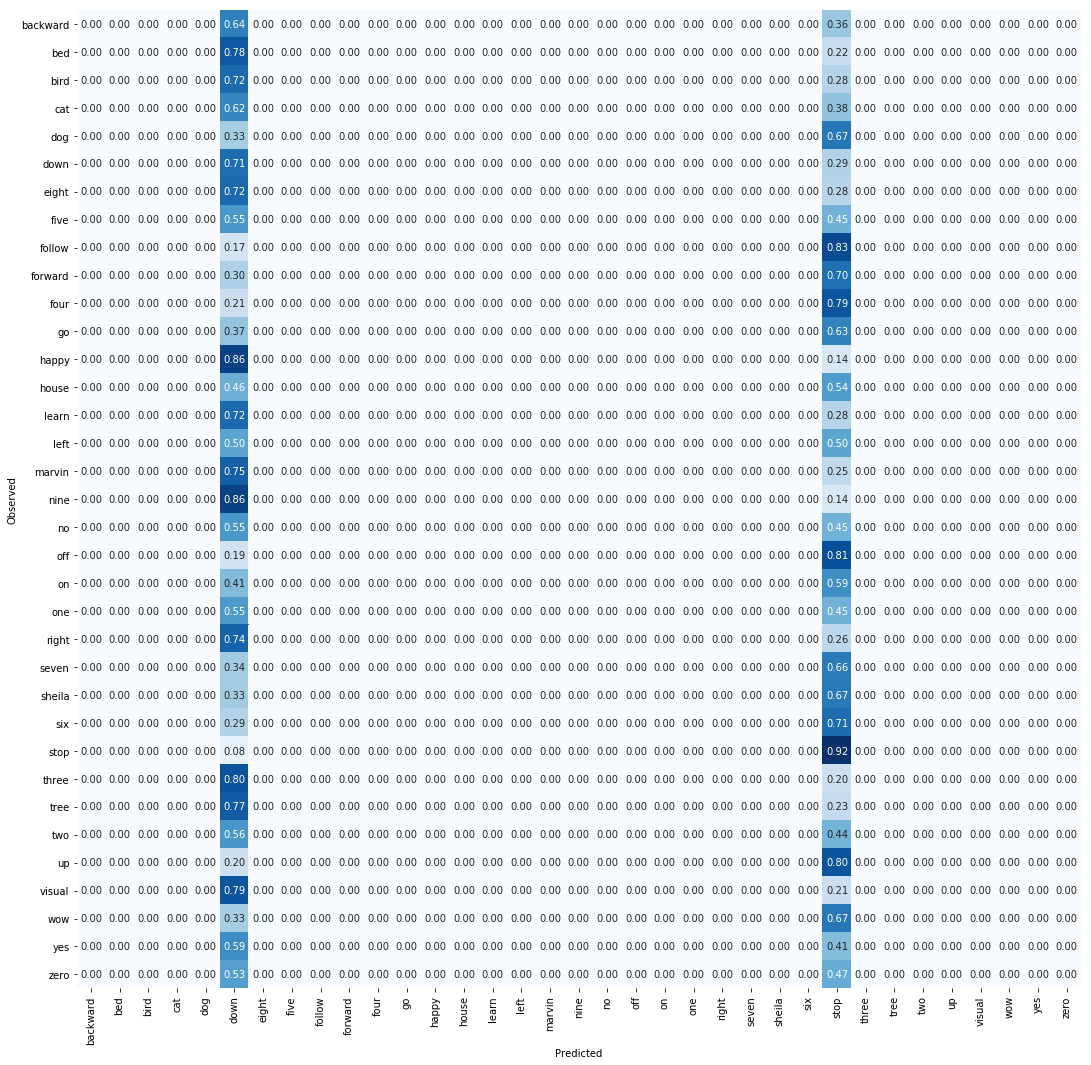

In [7]:
def plot_confusion_matrix(y_pred, y_test):
    y_pred_labels = np.array([words[y] for y in y_pred])
    conf_matrix = confusion_matrix(y_test, y_pred_labels)
    conf_matrix_percent = np.divide(conf_matrix.T, conf_matrix.sum(axis=1)).T
    fig, ax = plt.subplots(figsize=(18, 18))    
    sns.heatmap(conf_matrix_percent, cmap='Blues', ax=ax, annot=True, fmt='.2f', cbar=False)
    ax.set_xticklabels(words, rotation=90)
    ax.set_yticklabels(words, rotation=0)
    ax.set_ylabel('Observed')
    ax.set_xlabel('Predicted')
    plt.show()
    return conf_matrix_percent
    
y_pred_perceptron = model.predict_classes(x=X_test)
a = plot_confusion_matrix(y_pred_perceptron, y_test)

# Simple Feedforward Neural Network

In [8]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train[0].shape)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(35, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adadelta',
              metrics=['accuracy'])
model.fit(X_train, y_train_hot, batch_size=100, epochs=100, verbose=1,
          validation_data=(X_val, y_val_hot), callbacks=[early_stopping_monitor])

Train on 84843 samples, validate on 9981 samples
Epoch 1/100
84843/84843 [==============================] - 3s 31us/step - loss: 13.0348 - acc: 0.0478 - val_loss: 3.5464 - val_acc: 0.0410
Epoch 2/100
84843/84843 [==============================] - 2s 27us/step - loss: 3.2995 - acc: 0.0871 - val_loss: 3.2938 - val_acc: 0.1003
Epoch 3/100
84843/84843 [==============================] - 3s 30us/step - loss: 2.9835 - acc: 0.1577 - val_loss: 2.8625 - val_acc: 0.1914
Epoch 4/100
84843/84843 [==============================] - 3s 31us/step - loss: 2.8589 - acc: 0.1914 - val_loss: 3.2231 - val_acc: 0.1769
Epoch 5/100
84843/84843 [==============================] - 3s 30us/step - loss: 2.7931 - acc: 0.2073 - val_loss: 2.7302 - val_acc: 0.2074
Epoch 6/100
84843/84843 [==============================] - 3s 30us/step - loss: 2.7076 - acc: 0.2292 - val_loss: 2.6349 - val_acc: 0.2460
Epoch 7/100
84843/84843 [==============================] - 3s 30us/step - loss: 2.6335 - acc: 0.2458 - val_loss: 2.6494 - 

In [9]:
score = model.evaluate(x=X_test, y=y_test_hot)

for name, value in zip(model.metrics_names, score):
    print(name, value)

11005/11005 [==============================] - 0s 28us/step
loss 1.773540004612586
acc 0.48223534755303826


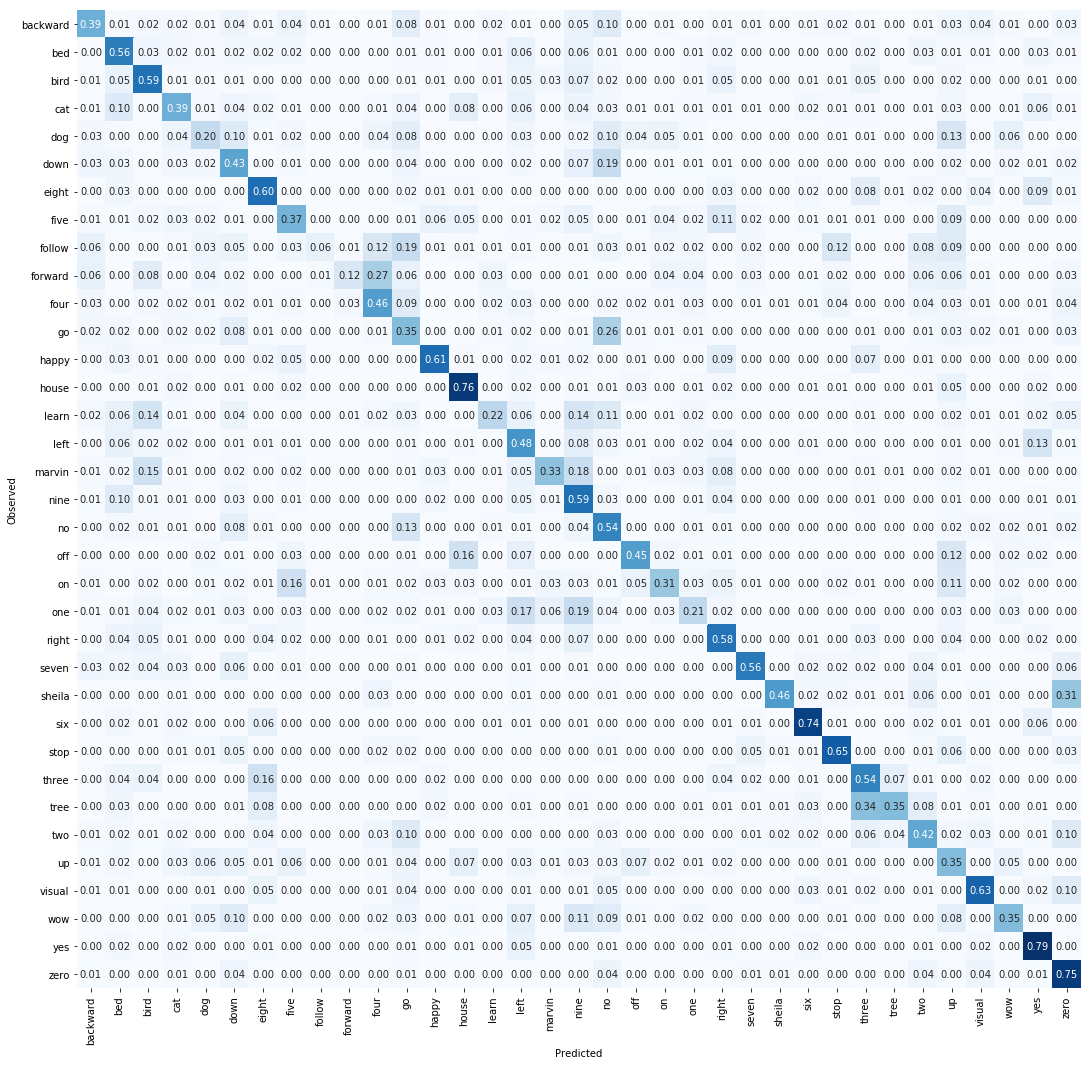

In [10]:
y_pred = model.predict_classes(x=X_test)
y_pred_ff = model.predict_classes(x=X_test)
b = plot_confusion_matrix(y_pred_ff, y_test)